In [51]:
import os
import numpy as np
import tifffile
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

from DLC_for_WBFM.utils.feature_detection.feature_pipeline import *
from DLC_for_WBFM.utils.feature_detection.utils_tracklets import *
from DLC_for_WBFM.utils.feature_detection.utils_detection import *
from DLC_for_WBFM.utils.feature_detection.visualization_tracks import *
from DLC_for_WBFM.utils.video_and_data_conversion.import_video_as_array import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
# Get the 3d bigtiff folder
bigtiff_folder = r'D:\More-stabilized-wbfm'

btf_fname_red = r'test2020-10-22_16-15-20_test4-channel-0-pco_camera1\test2020-10-22_16-15-20_test4-channel-0-pco_camera1bigtiff.btf'
btf_fname_red = os.path.join(bigtiff_folder, btf_fname_red)


In [176]:
ref_frames, all_matches, pairwise_matches, pairwise_conf, feature_matches = track_via_reference_frames(btf_fname_red, num_reference_frames=5)

  0%|                                                                     | 0/5 [00:00<?, ?it/s]

Pairwise matching all reference frames...


100%|█████████████████████████████████████████████████████████████| 5/5 [00:17<00:00,  3.41s/it]

WIP... aborting early


In [177]:
#print(pairwise_matches)
[print(f"{len(m)} matched neurons") for m in pairwise_matches.values()]
[print(f"{len(m)} matched features") for m in feature_matches.values()];

127 matched neurons
148 matched neurons
120 matched neurons
134 matched neurons
124 matched neurons
142 matched neurons
126 matched neurons
142 matched neurons
149 matched neurons
159 matched neurons
124 matched neurons
141 matched neurons
121 matched neurons
130 matched neurons
140 matched neurons
151 matched neurons
146 matched neurons
147 matched neurons
143 matched neurons
159 matched neurons
3753 matched features
3998 matched features
3174 matched features
3435 matched features
3731 matched features
4309 matched features
3122 matched features
4549 matched features
3967 matched features
4476 matched features
2913 matched features
3704 matched features
3191 matched features
3145 matched features
3190 matched features
3875 matched features
3697 matched features
4615 matched features
3822 matched features
4017 matched features


# Visualizing single-frame matches

Displaying 12/3174 matches
of a total of 27508 features


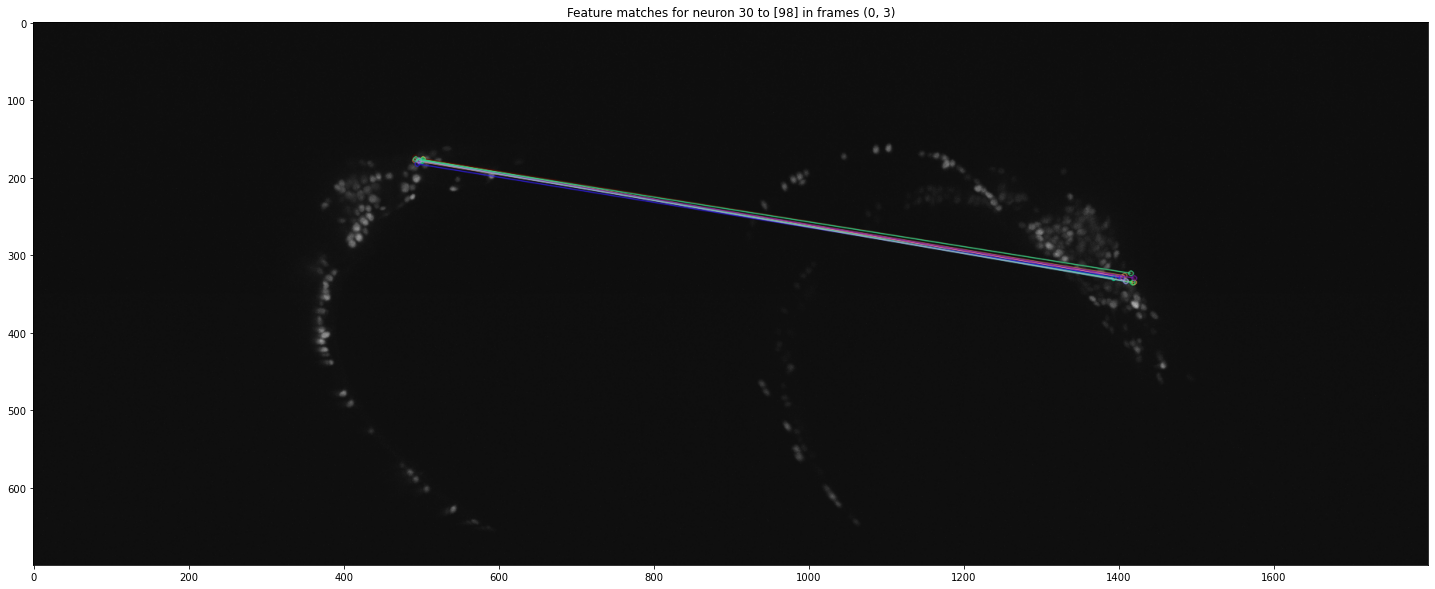

In [178]:
p = (0,3)
n0 = pairwise_matches[p][6][0]

plot_match_example(ref_frames, 
                       neuron_matches=pairwise_matches, 
                       feature_matches=feature_matches,
                       which_frame_pair=p, 
                       neuron0=n0, 
                       which_slice=12)

In [179]:
print(len(ref_frames[1].features_to_neurons))
print(len(feature_matches[(0,1)]))

27673
3753


In [180]:
# Print locations of neuron and the found keypoints
i = 1
frame = ref_frames[0]

this_neuron = frame.neuron_locs[i]
print(f"Neuron location ({i})")
print(this_neuron)

feature_ind = frame.get_features_of_neuron(i)
print("Feature location distance")
this_kp = []
for i2, kp in enumerate(frame.keypoints):
    if i2 in feature_ind:
        this_kp.append(kp.pt)
#this_kp = frame.keypoint_locs[feature_ind]
#print(this_kp)
#all_diff = [kp-this_neuron for kp in this_kp]
#print([round(np.linalg.norm(d),1) for d in all_diff])

Neuron location (1)
[  2.5        380.22750854 233.74761963]
Feature location distance


In [181]:
frame.keypoints[0].pt


(377.0, 304.0)

# Test global index generation

In [182]:
import networkx as nx
from DLC_for_WBFM.utils.feature_detection.utils_reference_frames import *


In [183]:
DG = build_digraph_from_matches(pairwise_matches, pairwise_conf, verbose=0)

In [184]:
#nx.draw(DG)

Largest connected component size:  19
Sizes and number of components:
[1, 157]
[2, 16]
[3, 20]
[4, 7]
[5, 62]
[6, 9]
[7, 4]
[8, 4]
[9, 4]
[10, 2]
[12, 1]
[14, 2]
[15, 3]
[16, 1]
[19, 2]


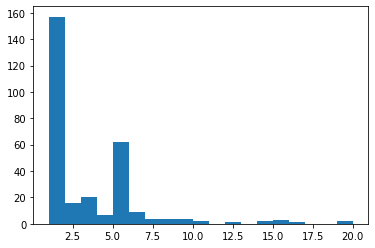

In [188]:
G = get_subgraph_with_strong_weights(DG, 0.0)
big_G, all_sz = calc_connected_components(G)
plt.hist(all_sz, bins=list(range(1,max(all_sz)+2)));

[vals, counts] = np.unique(all_sz, return_counts=True)
print("Sizes and number of components:")
for v, c in zip(vals, counts):
      print([v, c])

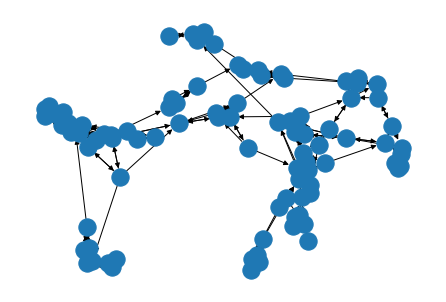

In [118]:
# All non-isolated nodes
core_G = nx.k_core(big_G, 1)
nx.draw(core_G)

# Clustering tests:


In [ ]:
# Cluster based on graph embedding:
# https://stackoverflow.com/questions/62902871/how-can-i-cluster-a-graph-g-created-in-networkx

from node2vec import Node2Vec
# Generate walks
node2vec = Node2Vec(big_DG, dimensions=2, walk_length=5, num_walks=10,workers=4)
# Learn embeddings 
model = node2vec.fit(window=10, min_count=1)
#model.wv.most_similar('1')
model.wv.save_word2vec_format("embedding.emb") #save the embedding in file embedding.emb

In [ ]:
from sklearn.cluster import KMeans

X = np.loadtxt("embedding.emb", skiprows=1) # load the embedding of the nodes of the graph
#print(X)
# sort the embedding based on node index in the first column in X
X=X[X[:,0].argsort()]; 
Z=X[0:X.shape[0],1:X.shape[1]]; # remove the node index from X and save in Z

kmeans = KMeans(n_clusters=300, random_state=0).fit(Z) # apply kmeans on Z
labels=kmeans.labels_  # get the cluster labels of the nodes.
print(labels)

In [ ]:
nx.draw(big_DG, node_color=labels)

In [ ]:
# Other clustering method:
# https://networkx.org/documentation/stable/auto_examples/algorithms/plot_blockmodel.html#sphx-glr-auto-examples-algorithms-plot-blockmodel-py
from collections import defaultdict

import matplotlib.pyplot as plt
import networkx as nx
from scipy.cluster import hierarchy
from scipy.spatial import distance


def create_hc(G):
    """Creates hierarchical cluster of graph G from distance matrix"""
    path_length = nx.all_pairs_shortest_path_length(G)
    distances = np.zeros((len(G), len(G)))
    for u, p in path_length:
        for v, d in p.items():
            distances[u][v] = d
    # Create hierarchical cluster
    Y = distance.squareform(distances)
    Z = hierarchy.complete(Y)  # Creates HC using farthest point linkage
    # This partition selection is arbitrary, for illustrive purposes
    membership = list(hierarchy.fcluster(Z, t=1.15))
    # Create collection of lists for blockmodel
    partition = defaultdict(list)
    for n, p in zip(list(range(len(G))), membership):
        partition[p].append(n)
    return list(partition.values())


G = big_DG.to_undirected()

# Extract largest connected component into graph H
H = G.subgraph(next(nx.connected_components(G)))
# Makes life easier to have consecutively labeled integer nodes
H = nx.convert_node_labels_to_integers(H)
# Create parititions with hierarchical clustering
partitions = create_hc(H)
# Build blockmodel graph
BM = nx.quotient_graph(H, partitions, relabel=True)

# Draw original graph
pos = nx.spring_layout(H, iterations=100)
plt.subplot(211)
nx.draw(H, pos, with_labels=False, node_size=10)

# Draw block model with weighted edges and nodes sized by number of internal nodes
node_size = [BM.nodes[x]["nnodes"] * 10 for x in BM.nodes()]
edge_width = [(2 * d["weight"]) for (u, v, d) in BM.edges(data=True)]
# Set positions to mean of positions of internal nodes from original graph
posBM = {}
for n in BM:
    xy = np.array([pos[u] for u in BM.nodes[n]["graph"]])
    posBM[n] = xy.mean(axis=0)
plt.subplot(212)
nx.draw(BM, posBM, node_size=node_size, width=edge_width, with_labels=False)
plt.axis("off")
plt.show()

# Testing feature matching

In [ ]:
import cv2
from DLC_for_WBFM.utils.video_and_data_conversion.import_video_as_array import *
im = get_single_volume(btf_fname_red, 0, num_slices=33)[0,...]

In [ ]:
im.shape
kp, d = detect_features(im, 1000)

In [ ]:
kp[0].pt



In [ ]:
dat = get_single_volume(btf_fname_red, 0, num_slices=33)
dat.shape[1:]

In [ ]:
cv2.KeyPoint.convert(kp2[0,...])
#kp3 = cv2.KeyPoint_convert(kp2)

In [ ]:
a = [1, 3, 5, 7]
b = [3, 5, 6]

In [ ]:
[a.index(val) if val in a for val in b]


In [ ]:
a[0,0]

# Test feature detectors

In [171]:
dat = get_single_volume(btf_fname_red, 0, 33, 0.15)

import scipy.ndimage as ndi
dat_max = ndi.maximum_filter(dat, size=(5,1,1))

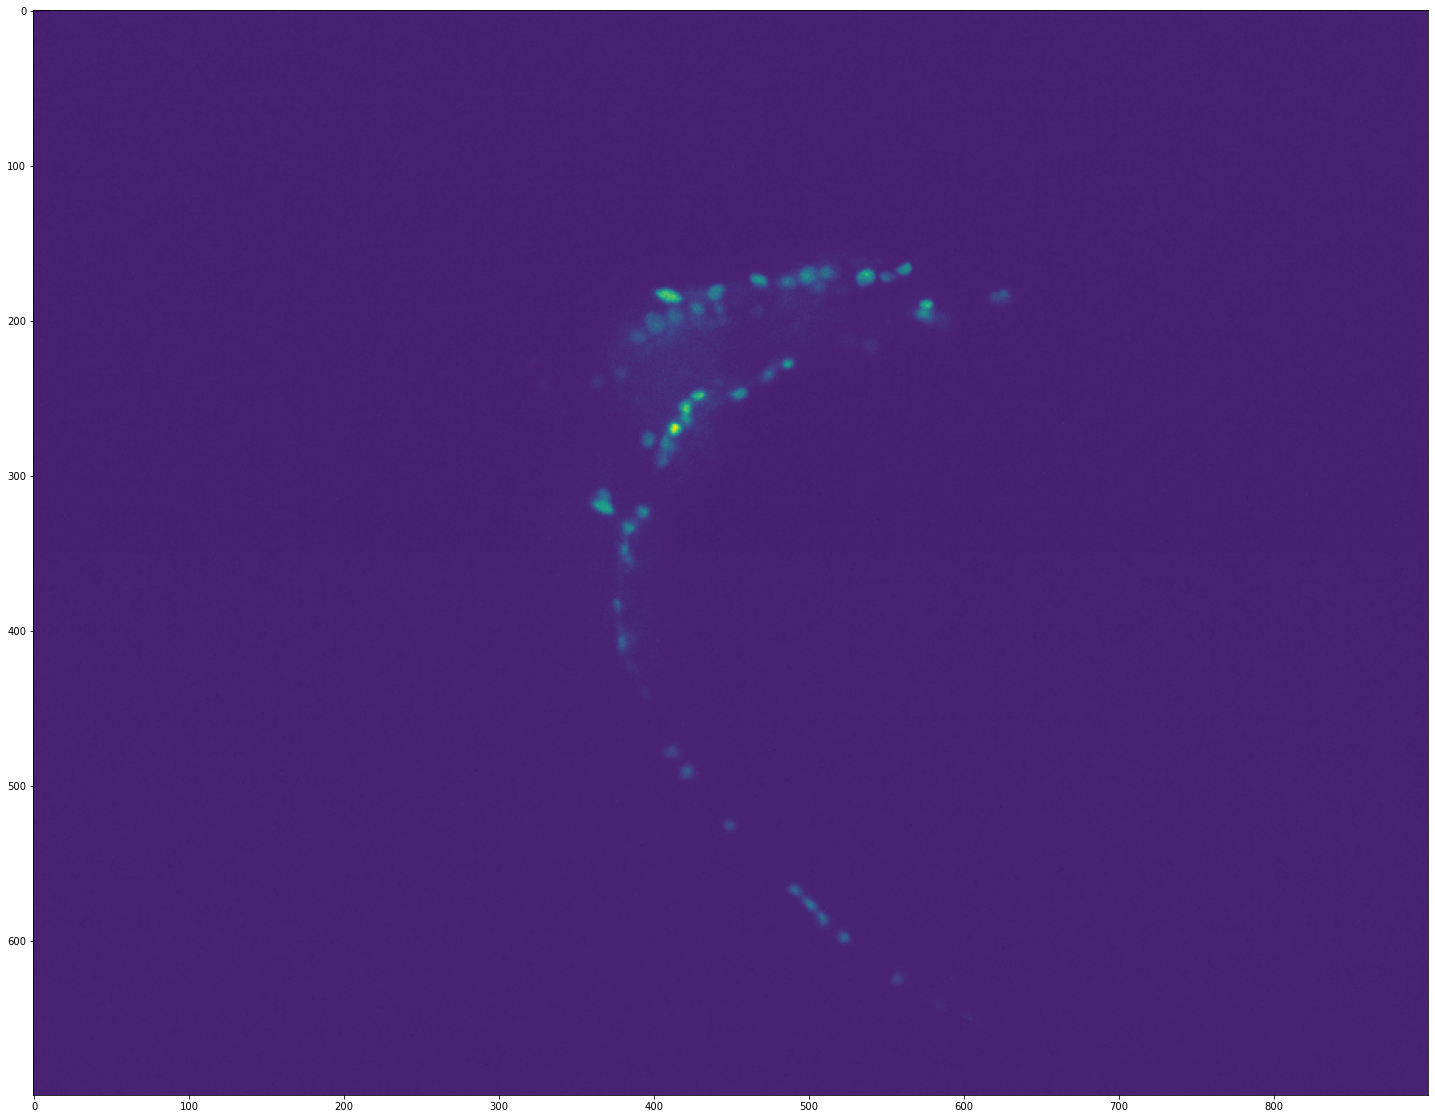

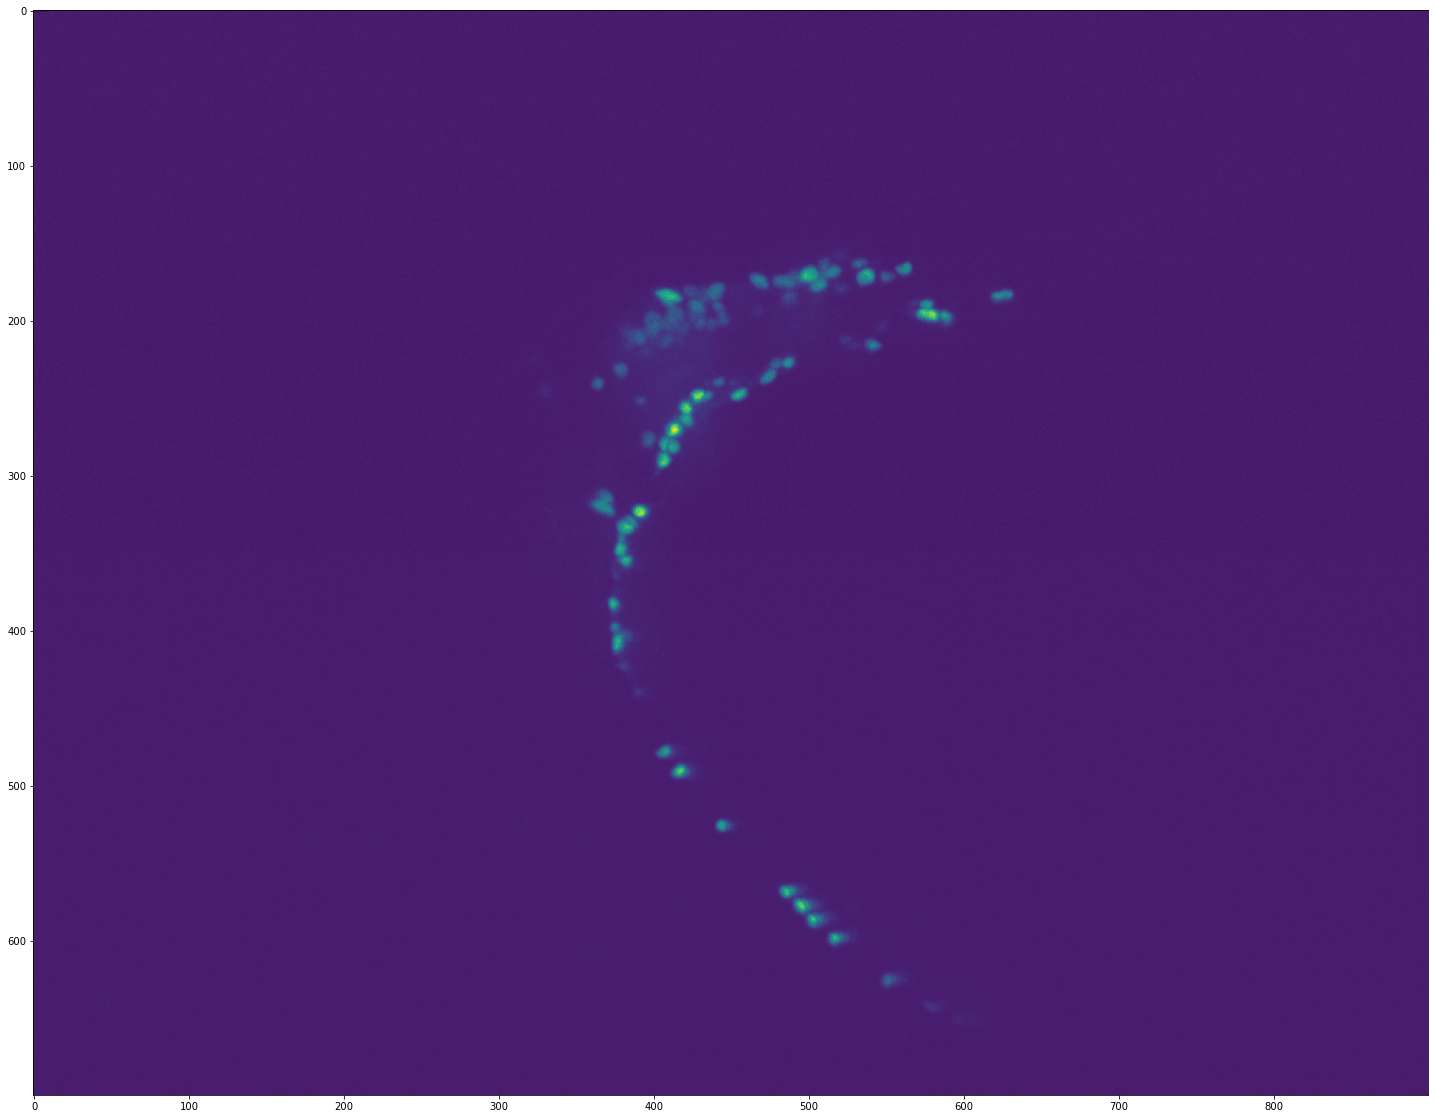

In [175]:
%matplotlib inline
plt.figure(figsize=(25,45))
plt.imshow(dat[21,...])
plt.figure(figsize=(25,45))
plt.imshow(dat_max[21,...])

In [151]:
print(dat[10:15,-1,-1])
print(dat[1,...])

print(dat_max[1,...])

[14 14 13 14 13]
[[ 0  0  0 ... 14 13 15]
 [16 15 14 ... 14 14 14]
 [14 14 14 ... 14 14 14]
 ...
 [15 14 15 ... 14 15 14]
 [14 15 14 ... 15 14 14]
 [14 14 13 ... 15 15 13]]
[[ 0  0  0 ... 15 14 15]
 [16 15 15 ... 14 14 14]
 [15 15 15 ... 14 14 15]
 ...
 [15 15 15 ... 15 15 15]
 [15 16 15 ... 16 15 15]
 [15 14 14 ... 15 16 14]]


In [152]:
dat_max.shape

(33, 700, 900)